#### Начало: загрузка, переименование

In [1]:
from data_utils import get_mem_usage, new_columns, attrs

import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from typing import Optional

import os
import phik

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier

import joblib

import warnings

plt.rcParams['figure.figsize'] = [20, 6]
np.set_printoptions(precision=4, suppress=True)
pd.options.display.float_format = '{:.4f}'.format

RANDOM_STATE = 42
SAMPLE_SIZE = 10**5


from dotenv import load_dotenv

load_dotenv()

env_var_names = [
    'LOCAL_DATA_PATH', 'LOCAL_MODEL_PATH', 
    'S3_DATA_PATH', 'S3_MODEL_PATH', 
    'DATA_PARQUET', 'DATA_CSV', 'TRAIN_PARQUET', 'TEST_PARQUET', 
    'MODEL_CBM'
]

for var in env_var_names:
    globals()[var] = os.getenv(var)

def display_nans_history(df, col):
    print(f"Пропущенные значения в столбце {col} ({df.attrs[col][0]})")

    summary_df = df.groupby('fetch_date')[col].agg(['count', lambda x: x.isna().sum()])
    summary_df.columns = ['count', 'nan_sum']

    summary_df.reset_index(inplace=True)
    summary_df['fetch_date'] = summary_df['fetch_date'].dt.strftime('%Y-%m-%d')

    total_row = pd.DataFrame({
        'fetch_date': ['Total'],
        'count': [summary_df['count'].sum()],
        'nan_sum': [summary_df['nan_sum'].sum()]
    })
    summary_df = pd.concat([summary_df, total_row], ignore_index=True)

    summary_df.index = [''] * len(summary_df)
    display(summary_df.style.format({
        'count': '{:,.0f}',
        'nan_sum': '{:,.0f}'
    }))


def display_statistics(data):
    indicators = []
    for col in data.columns:
        indicators.append({
            'type': data[col].dtypes,
            'types': set(map(lambda v: type(v).__name__, data[col].unique())),
            'count' : data[col].count(),
            'NaNs' : data[col].isna().sum(),
            'zero_values': data[col].eq(0).sum(),
            'nunique': data[col].nunique(),
            'unique-top5': data[col].value_counts().head().to_dict()
        })
    
    return pd.DataFrame(indicators, index = [x for x in data.columns])

In [2]:
if os.path.exists(LOCAL_DATA_PATH + DATA_PARQUET):
    df = pd.read_parquet(LOCAL_DATA_PATH + DATA_PARQUET)
    print(f"Файл {DATA_PARQUET} существует и был открыт.")

else:
    dtype_spec = {
        'age': 'str',
        'tenure_months': 'str',
        'client_type_1m': 'str',
        'ind_spouse_employee': 'str',
    }

    df = pd.read_csv(
        LOCAL_DATA_PATH + DATA_CSV, 
        dtype=dtype_spec,
        parse_dates=['fetch_date', 'registration_date', 'last_date_as_primary'], 
        date_format='%Y-%m-%d', 
        low_memory=False,
        header=0, 
        names=list(new_columns.values())
    )

    df.attrs = attrs
    df.to_parquet(LOCAL_DATA_PATH + DATA_PARQUET)
    print(f"Файл данных {DATA_PARQUET} был сгенерирован и сохранен.")

display(df.head())
get_mem_usage()

Файл data.parquet существует и был открыт.


,fetch_date,id,ind_employee,country_of_residence,gender,age,registration_date,ind_new_client,tenure_months,client_relationship_status,...,ind_1m_mortgage,ind_1m_pension_plan,ind_1m_loans,ind_1m_tax_account,ind_1m_credit_card,ind_1m_securities,ind_1m_home_acc,ind_1m_salary_acc,ind_1m_pension_obligation_account,ind_1m_debit_account
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0000,6,1.0000,...,0,0,0,0,0,0,0,0.0000,0.0000,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0000,35,1.0000,...,0,0,0,0,0,0,0,0.0000,0.0000,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0000,35,1.0000,...,0,0,0,0,0,0,0,0.0000,0.0000,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0000,35,1.0000,...,0,0,0,0,0,0,0,0.0000,0.0000,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0000,35,1.0000,...,0,0,0,0,0,0,0,0.0000,0.0000,0


Общая память: 33.7 GB
Доступная память: 15.9 GB


In [3]:
display_statistics(df)

,type,types,count,NaNs,zero_values,nunique,unique-top5
fetch_date,datetime64[ns],{Timestamp},13647309,0,0,17,"{2016-05-28 00:00:00: 931453, 2016-04-28 00:00..."
id,int64,{int64},13647309,0,0,956645,"{538031: 17, 538018: 17, 538021: 17, 538023: 1..."
ind_employee,object,"{str, NoneType}",13619575,27734,0,5,"{'N': 13610977, 'B': 3566, 'F': 2523, 'A': 249..."
country_of_residence,object,"{str, NoneType}",13619575,27734,0,118,"{'ES': 13553710, 'FR': 5161, 'AR': 4835, 'DE':..."
gender,object,"{str, NoneType}",13619505,27804,0,2,"{'V': 7424252, 'H': 6195253}"
age,object,{str},13647309,0,0,121,"{' 23': 779884, ' 22': 736314, ' 24': 734785, ..."
registration_date,datetime64[ns],"{Timestamp, NaTType}",13619575,27734,0,6756,"{2014-07-28 00:00:00: 57389, 2014-10-03 00:00:..."
ind_new_client,float64,{float64},13619575,27734,12808368,2,"{0.0: 12808368, 1.0: 811207}"
tenure_months,object,{str},13647309,0,0,259,"{' 12': 243160, ' 21': 214795, ' 1..."
client_relationship_status,float64,{float64},13619575,27734,0,2,"{1.0: 13594782, 99.0: 24793}"


#### Создание таргета

In [4]:
def count_changes(grouped, type = 0):
    diffs = grouped.diff()

    if type == 0:
        changes = diffs.ne(0) & diffs.notna()
    else:
        changes = diffs.eq(type) & diffs.notna()
    changes_count = changes.groupby(df['id']).sum()
    
    return changes_count.sum().sum()


product_features = [col for col in df.columns if col.startswith('ind_1m_')]

grouped = df.groupby('id')[product_features]

num_of_periods = df['fetch_date'].nunique()
num_of_clients = df['id'].nunique()
num_of_interactions = grouped.sum().sum(axis=1).mean()

print(f"Среднее количество периодов пользования продуктами: {num_of_interactions:.2f} в течение {num_of_periods} периодов")
print(f"Среднее количество продуктов на одного клиента: {grouped.mean().sum(axis=1).mean():.2f}")
print(f"Доля клиентов, пользующихся в среднем не более, чем одним продуктом: {(grouped.mean().sum(axis=1) <=1).mean():.2%}")

sum_of_interactions = grouped.sum().sum(axis=1)
print(f"Доля клиентов, не пользующихся никакими продуктами: {(sum_of_interactions ==0).mean():.2%}")
print()

print(f"Доля клиентов, у которых в начале и в конце истории одинаковый набор продуктов: "
        f"{(grouped.first() == grouped.last()).all(axis=1).sum() / num_of_clients:.2%},")
print(f"Доля клиентов, у которых ни разу не менялся набор продуктов: "
        f"{(grouped.first() == grouped.mean()).all(axis=1).sum() / num_of_clients:.2%}")
print()

interactions_total = df[product_features].count().sum() - grouped.first().count().sum() # без первых строк, которые изменениями не являются

previous_values = grouped.shift(1)
continue_0 = ((previous_values == 0) & (df[product_features] == 0)).sum().sum()
continue_1 = ((previous_values == 1) & (df[product_features] == 1)).sum().sum()
changes = count_changes(grouped)
change_0_1 = count_changes(grouped, 1)
change_1_0 = count_changes(grouped, -1)

print(f"Всего взаимодействий: {interactions_total:,.0f} (100%),\n"
      f" - с изменением состояния: {changes:,.0f} ({changes / interactions_total:.2%}):\n"
      f" - - из них покупок (0->1): {change_0_1:,.0f} ({change_0_1 / interactions_total:.2%}),\n"
      f" - - отказов от услуг (1->0): {change_1_0:,.0f} ({change_1_0 / interactions_total:.2%}),\n"
      f" - без изменения состояния: {continue_0+continue_1:,.0f} ({(continue_0+continue_1) / interactions_total:.2%}):\n"
      f" - - продолжили пользоваться (1->1): {continue_1:,.0f} ({continue_1 / interactions_total:.2%}),\n"
      f" - - продолжили не пользоваться (0->0): {continue_0:,.0f} ({continue_0 / interactions_total:.2%})")

del previous_values

Среднее количество периодов пользования продуктами: 20.86 в течение 17 периодов
Среднее количество продуктов на одного клиента: 1.30
Доля клиентов, пользующихся в среднем не более, чем одним продуктом: 70.54%
Доля клиентов, не пользующихся никакими продуктами: 23.57%

Доля клиентов, у которых в начале и в конце истории одинаковый набор продуктов: 79.94%,
Доля клиентов, у которых ни разу не менялся набор продуктов: 74.56%

Всего взаимодействий: 304,550,014 (100%),
 - с изменением состояния: 1,097,241 (0.36%):
 - - из них покупок (0->1): 563,308 (0.18%),
 - - отказов от услуг (1->0): 533,933 (0.18%),
 - без изменения состояния: 303,452,381 (99.64%):
 - - продолжили пользоваться (1->1): 18,174,160 (5.97%),
 - - продолжили не пользоваться (0->0): 285,278,221 (93.67%)


In [5]:
get_mem_usage()

Общая память: 33.7 GB
Доступная память: 20.8 GB


In [6]:
shifted_values = grouped.shift(-1)
df_targets = ((df[product_features] == 0) & (shifted_values == 1)).astype(int).add_prefix('target__')

for col in df_targets.columns:
    df[col] = df_targets[col]

del shifted_values, df_targets

targets = [col for col in df.columns if col.startswith("target__")]

last_row_mask = df.groupby('id')['id'].transform('shift', -1).notna()
df = df[last_row_mask]

grouped_0 = (df.groupby('id')[targets].sum().sum(axis=1) == 0)
df = df[~df.id.isin(grouped_0[grouped_0].index)]

df.attrs['target__'] = targets

get_mem_usage()

Общая память: 33.7 GB
Доступная память: 16.6 GB


In [7]:
split_date = '2016-02-28'

df[df.fetch_date > split_date].to_parquet(LOCAL_DATA_PATH + TEST_PARQUET)
df = df[df.fetch_date <= split_date]
df.to_parquet(LOCAL_DATA_PATH + TRAIN_PARQUET)

##### 2-я загрузка

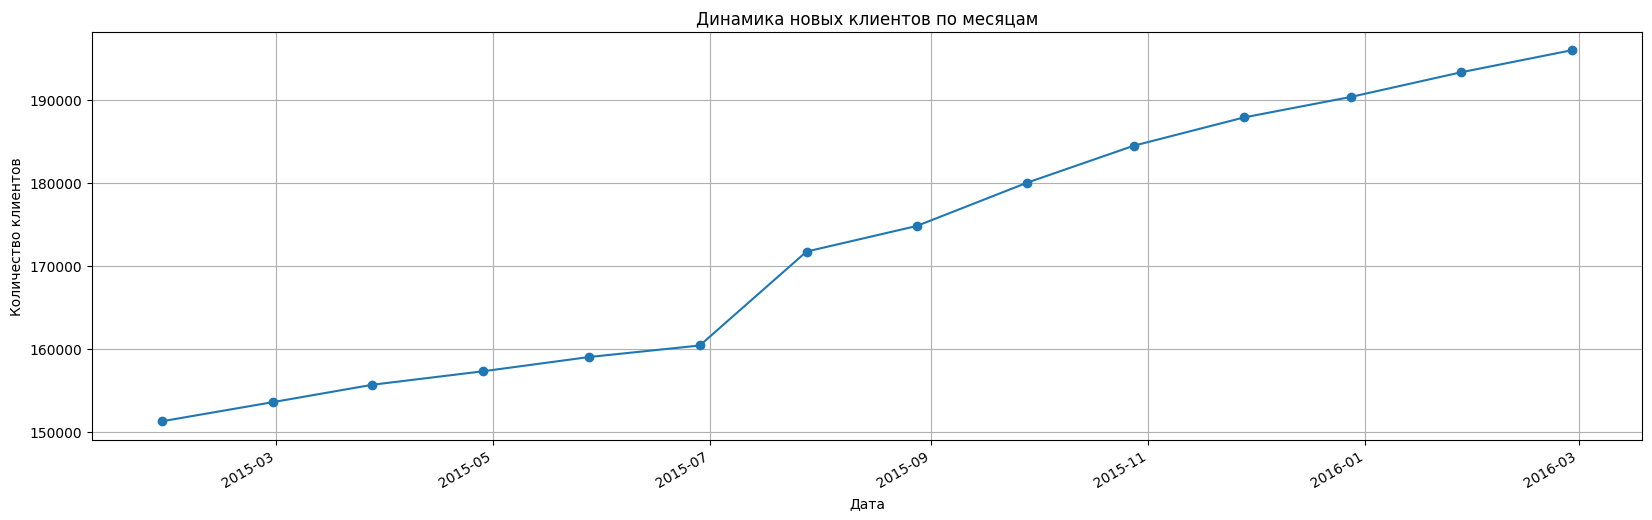

In [8]:
df.groupby('fetch_date')['id'].nunique().plot.line(marker = 'o')

plt.title('Динамика новых клиентов по месяцам')
plt.xlabel('Дата')
plt.ylabel('Количество клиентов')
plt.grid(True)

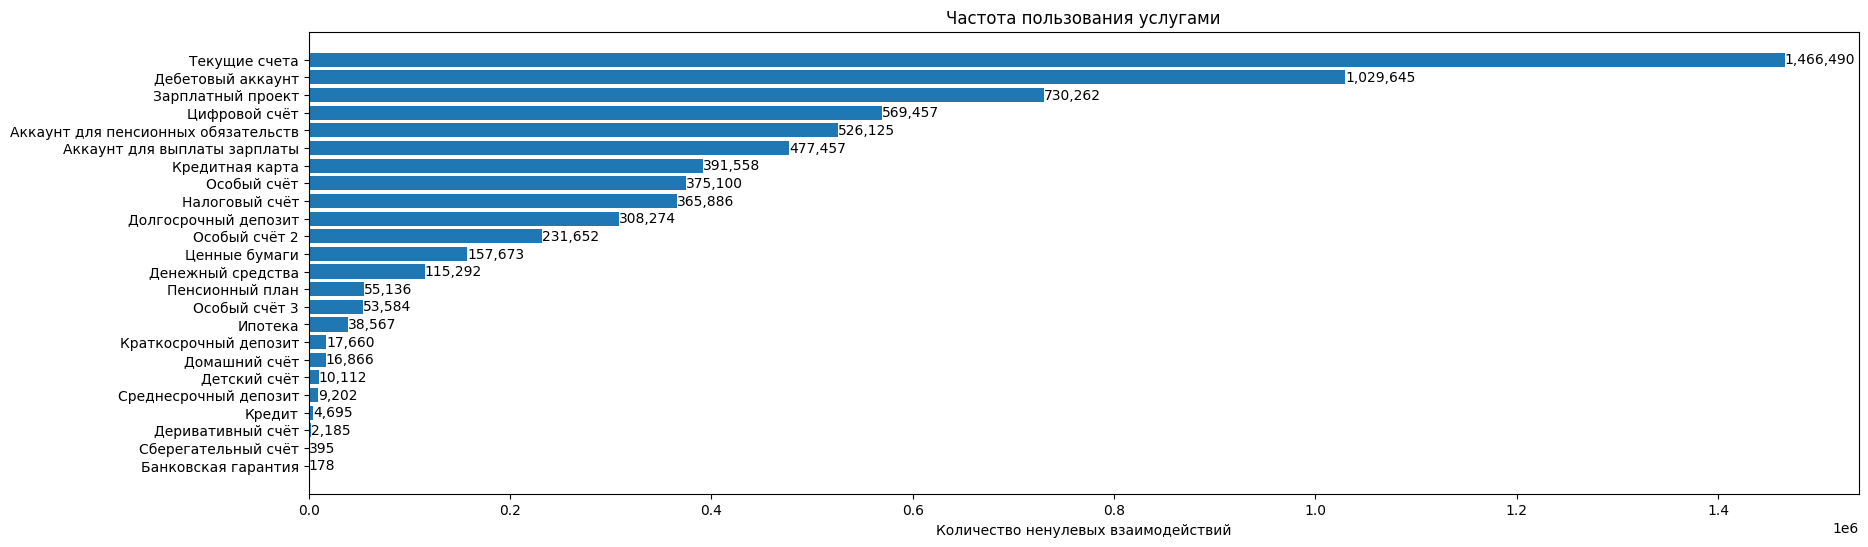

In [9]:
interactions_products = df[product_features].sum().to_frame().sort_values(0)

values = interactions_products[0]
category = interactions_products.index.map(lambda x: interactions_products.attrs[x][0])

plt.figure(figsize=(20,6))
plt.barh(category, values)

for index, value in enumerate(values):
    plt.text(value, index, f"{value:,.0f}", va='center')

plt.xlabel('Количество ненулевых взаимодействий')
plt.title('Частота пользования услугами')
plt.show()

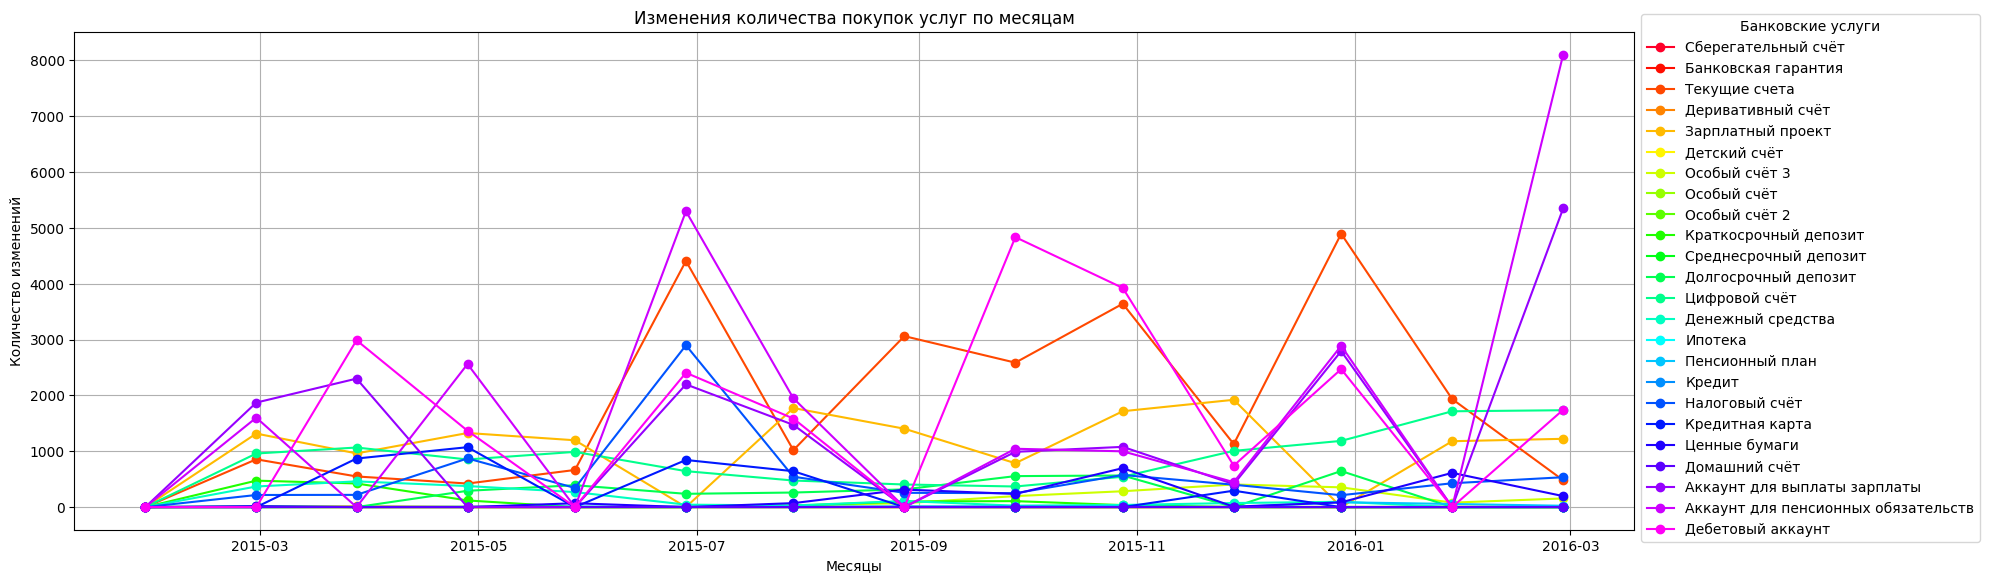

In [10]:
df_targets = df[['fetch_date'] + product_features].set_index('fetch_date')

increments_df = df_targets.groupby('fetch_date').sum().diff().fillna(0) 
increments_df = increments_df[increments_df > 0].fillna(0)

plt.figure(figsize=(20, 6))

num_colors = increments_df.shape[1]
cmap = plt.colormaps.get_cmap('gist_rainbow')

for i, column in enumerate(increments_df.columns):
    color = cmap(i / num_colors) 
    plt.plot(increments_df.index, increments_df[column], marker='o', color=color, label=df.attrs[column][0])

plt.title('Изменения количества покупок услуг по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Количество изменений')
plt.legend(title='Банковские услуги', bbox_to_anchor=(1, 1.05), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

del df_targets

##### Здесь

In [11]:
nan_counts = df.isna().sum(axis=1)

print(f"Распределение количества NaNs:")
display(nan_counts.value_counts().to_frame())
print(f"Количество строк с NaN > 10: {(nan_counts > 10).sum()}")

Распределение количества NaNs:


,count
2,1997101
3,376222
7,19855
5,9605
6,7984
20,1942
4,1839
1,857
22,433
9,5


Количество строк с NaN > 10: 2375


In [12]:
display_nans_history(df.loc[nan_counts < 10], 'client_segment')

Пропущенные значения в столбце client_segment (Сегментация)


,fetch_date,count,nan_sum
,2015-01-28,"150,640",29
,2015-02-28,"152,956",24
,2015-03-28,"155,122",20
,2015-04-28,"156,848",11
,2015-05-28,"158,839",8
,2015-06-28,"160,364",0
,2015-07-28,"166,402","5,319"
,2015-08-28,"171,478","3,332"
,2015-09-28,"174,492","5,533"
,2015-10-28,"179,621","4,861"


In [13]:
print(f"Количество пропущенных значений переменной 'last_date_as_primary' "
      f"({df.attrs['last_date_as_primary'][0]}): "
      f"{df['last_date_as_primary'].isna().sum() / len(df) :.2%}")
print(f"Количество пропущенных значений переменной 'ind_spouse_employee' "
      f"({df.attrs['ind_spouse_employee'][0]}): "
      f"{df['ind_spouse_employee'].isna().sum() / len(df) :.2%}")
print(f"Уникальные значения переменной 'address_type' "
      f"({df.attrs['address_type'][0]}): "
      f"NaN: {df['address_type'].isna().sum() / len(df) :.2%}, '1.0': "
      f"{df['address_type'].value_counts().loc[1.0] / len(df) :.2%}")

print(f"Самое частое значение переменной 'ind_employee' "
      f"({df.attrs['ind_employee'][0]}): "
      f"'N': {df['ind_employee'].value_counts()['N'] / len(df) :.2%}")

print(f"Количество пропущенных значений переменной 'gender' ({df.attrs['gender'][0]}): "
        f"{df['gender'].isna().sum() / len(df) :.4%}")

print(f"Уникальные значения переменной 'country_of_residence' ({df.attrs['country_of_residence'][0]}): "
        f"'ES': {df['country_of_residence'].value_counts().loc['ES'] / len(df):.2%}, все остальные: {len(df[df['country_of_residence'] != 'ES']) / len(df):.2%}")
print(f"Уникальные значения переменной 'ind_resident' ({df.attrs['ind_resident'][0]}): "
        f"'S': {df['ind_resident'].value_counts().loc['S'] / len(df):.2%}, все остальные: {df['ind_resident'].value_counts().loc['N'] / len(df):.2%}")

Количество пропущенных значений переменной 'last_date_as_primary' (Последняя дата, когда клиент был премиальным): 99.93%
Количество пропущенных значений переменной 'ind_spouse_employee' (Признак супруга работника): 99.97%
Уникальные значения переменной 'address_type' (Тип адреса): NaN: 0.10%, '1.0': 99.90%
Самое частое значение переменной 'ind_employee' (Статус занятости): 'N': 99.75%
Количество пропущенных значений переменной 'gender' (Пол): 0.0991%
Уникальные значения переменной 'country_of_residence' (Страна резидентства): 'ES': 99.61%, все остальные: 0.39%
Уникальные значения переменной 'ind_resident' (Если страна проживания совпадает со страной банка): 'S': 99.61%, все остальные: 0.29%


In [14]:
print(df.attrs['age'][0])
print(
    df['age'][df['age'] != ' NA']
    .apply(int)
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.99])
    .to_frame()['age']
    .apply(lambda x: f"{x:.0f}")
)

Возраст
count    2413468
mean          43
std           14
min            2
10%           24
25%           32
50%           42
75%           51
99%           84
max          116
Name: age, dtype: object


In [15]:
print(df.attrs['tenure_months'][0])
print(df['tenure_months'].value_counts())

Стаж клиента (в месяцах)
tenure_months
     12    41337
     10    35784
      5    35527
      9    35002
      3    32442
           ...  
    250      143
    251       90
    252       69
    253       43
-999999        1
Name: count, Length: 256, dtype: int64


In [16]:
print(df.attrs['client_type_1m'][0])
print(df['client_type_1m'].value_counts(dropna=False))

Тип клиента в начале месяца
client_type_1m
1.0     1566476
1        816233
None      30220
3.0        1241
3           664
P           415
2.0         266
2           201
4.0          91
4            36
Name: count, dtype: int64


In [17]:
print(df.attrs['client_activity_1m'][0])
print(df['client_activity_1m'].value_counts(dropna=False))

Тип клиента в начале месяца
client_activity_1m
A       2176652
I        206524
None      30220
P          2032
R           415
Name: count, dtype: int64


In [18]:
print(f"{df.attrs['province_code'][0]}")
print(df['province_code'].unique())
print()
print(f"{df.attrs['province_name'][0]}")
print(df['province_name'].unique())

Код провинции (адреса клиента)
[29. 10. 49. 37. 27. 45. 41.  3.  7. 47. 46. 36. 15. 13. 50.  2.  8. 28.
  9. 39.  6. 40. 34. 16. 23. 11. 24. 33. 26. 38. 18. 21. 25. 48.  4. 35.
 19. 20. 30. 12. 14. 31. 43. 22. 32. 17. nan  1.  5. 42. 44. 52. 51.]

Имя провинции
['MALAGA' 'CACERES' 'ZAMORA' 'SALAMANCA' 'LUGO' 'TOLEDO' 'SEVILLA'
 'ALICANTE' 'BALEARS, ILLES' 'VALLADOLID' 'VALENCIA' 'PONTEVEDRA'
 'CORUÑA, A' 'CIUDAD REAL' 'ZARAGOZA' 'ALBACETE' 'BARCELONA' 'MADRID'
 'BURGOS' 'CANTABRIA' 'BADAJOZ' 'SEGOVIA' 'PALENCIA' 'CUENCA' 'JAEN'
 'CADIZ' 'LEON' 'ASTURIAS' 'RIOJA, LA' 'SANTA CRUZ DE TENERIFE' 'GRANADA'
 'HUELVA' 'LERIDA' 'BIZKAIA' 'ALMERIA' 'PALMAS, LAS' 'GUADALAJARA'
 'GIPUZKOA' 'MURCIA' 'CASTELLON' 'CORDOBA' 'NAVARRA' 'TARRAGONA' 'HUESCA'
 'OURENSE' 'GIRONA' None 'ALAVA' 'AVILA' 'SORIA' 'TERUEL' 'MELILLA'
 'CEUTA']


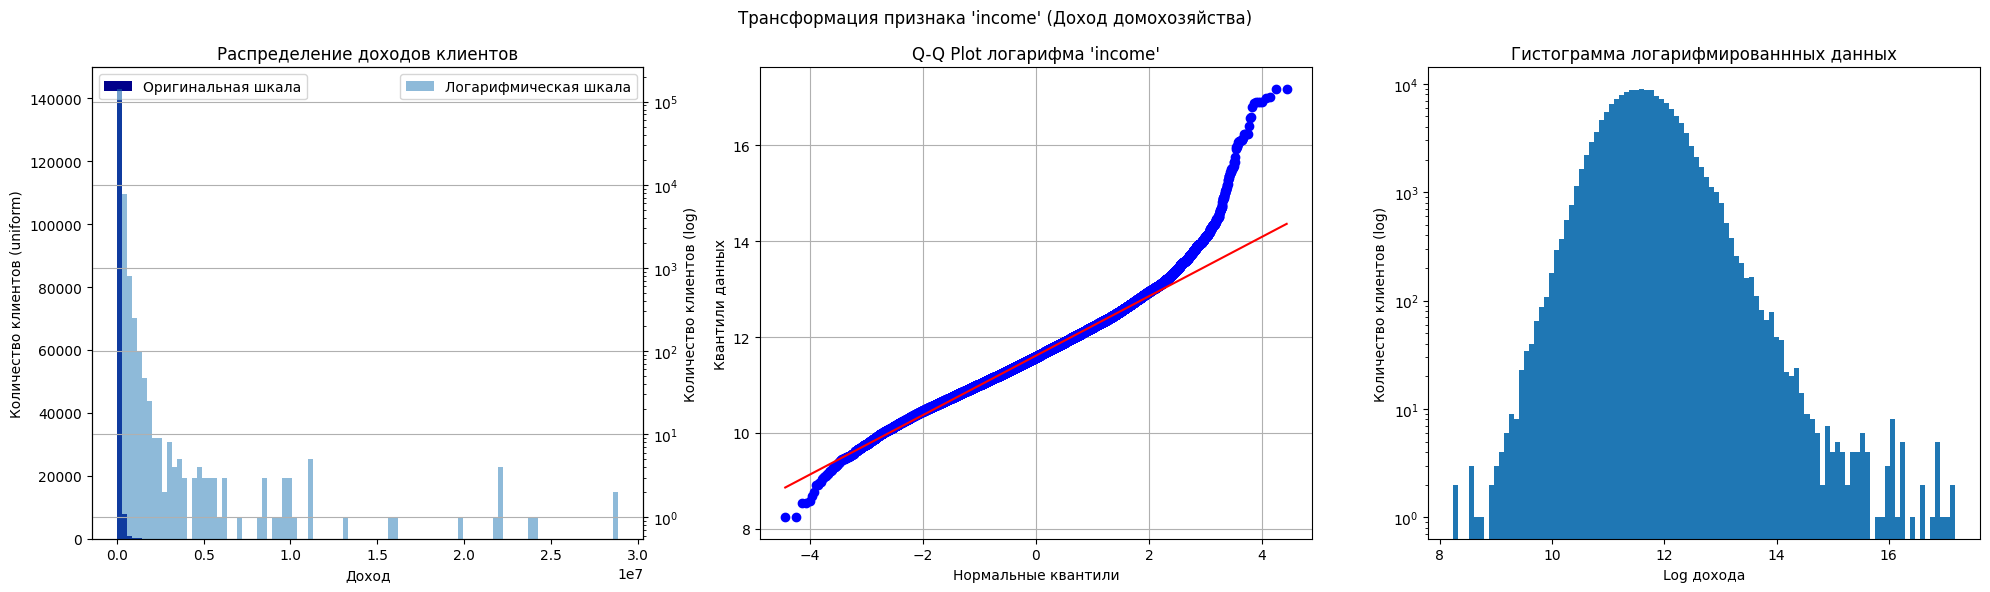

In [19]:
df_incomes = df.groupby('id')['income'].last()

fig, ax = plt.subplots(nrows=1, ncols= 3, figsize=(20, 6))
plt.suptitle(f"Трансформация признака 'income' ({df.attrs['income'][0]})")

plt.subplot(131)

plt.hist(df_incomes, bins=100, color='darkblue', label = 'Оригинальная шкала')
plt.title('Распределение доходов клиентов')
plt.xlabel('Доход')
plt.ylabel('Количество клиентов (uniform)')
plt.legend(loc='upper left')

plt.twinx()
plt.hist(df_incomes, bins=100, alpha=0.5, label = 'Логарифмическая шкала')
plt.yscale('log')
plt.ylabel('Количество клиентов (log)')
plt.grid(True)
plt.legend()

plt.subplot(132)

income_log = np.log(df_incomes).dropna()

stats.probplot(income_log, dist="norm", plot=plt.subplot(132))
plt.title("Q-Q Plot логарифма 'income'")
plt.xlabel('Нормальные квантили')
plt.ylabel('Квантили данных')
plt.grid(True)

plt.subplot(133)

plt.title('Гистограмма логарифмированнных данных')
plt.xlabel('Log дохода')
plt.ylabel('Количество клиентов (log)')
plt.hist(income_log, bins=100, log=True)

plt.tight_layout()
plt.show()

In [20]:
def process_na(df):
    df = df[df.isna().sum(axis=1) < 10]
    df = df[df['ind_deceased'] == 'N']
    return df


def process_df(df):
    df['number_of_products'] = df[[col for col in df.columns if col.startswith('ind_1m_')]].sum(axis=1)
    df['fetch_year'] = df['fetch_date'].dt.year
    df['fetch_month'] = df['fetch_date'].dt.month

    df['tenure_months'] = (
        (df['fetch_date'].dt.year - df['registration_date'].dt.year) * 12 
        + (df['fetch_date'].dt.month - df['registration_date'].dt.month)
    )
    
    df['income'] = np.log(df['income'])
    df['client_type_1m'] = pd.to_numeric(df['client_type_1m'], errors='coerce').replace('P', 5)
    df['client_segment'] = df['client_segment'].map({None:0, '02 - PARTICULARES': 2, '03 - UNIVERSITARIO': 3, '01 - TOP': 1})

    df.fillna({
        'province_code': 0, 
        'gender': 'V',
        'client_activity_1m': 'N',
        'entry_channel': 'UNK',
        'income': df['income'].median(),
        'client_type_1m': 0
        }, inplace=True)

    columns_to_int = ['age', 'tenure_months', 'ind_new_client', 'client_relationship_status', 'ind_client_activity', 'province_code', 'client_type_1m', 'number_of_products']
    df[columns_to_int] = df[columns_to_int].astype(int)

    df = df.drop(
        columns = [
            'fetch_date', 'id',
            'ind_deceased', 'ind_spouse_employee', 'last_date_as_primary',
            'address_type', 'ind_employee', 'country_of_residence', 
            'ind_resident', 'province_name', 'registration_date'
        ]
    )

    return df.fillna(0)

In [21]:
df = process_na(df)
df = process_df(df)

df.head()

,gender,age,ind_new_client,tenure_months,client_relationship_status,client_type_1m,client_activity_1m,ind_foreigner,entry_channel,province_code,...,target__ind_1m_tax_account,target__ind_1m_credit_card,target__ind_1m_securities,target__ind_1m_home_acc,target__ind_1m_salary_acc,target__ind_1m_pension_obligation_account,target__ind_1m_debit_account,number_of_products,fetch_year,fetch_month
0,H,35,0,0,1,1,A,N,KHL,29,...,0,0,0,0,0,0,0,1,2015,1
9,H,23,0,29,1,1,I,N,KHE,10,...,0,0,0,0,0,0,0,1,2015,1
12,H,23,0,29,1,1,A,N,KHE,49,...,0,0,0,0,0,0,1,1,2015,1
32,V,23,0,29,1,1,A,N,KHE,37,...,0,0,0,0,0,0,0,1,2015,1
36,H,23,0,29,1,1,A,N,KHE,27,...,0,0,0,0,0,0,0,1,2015,1


In [22]:
features = [col for col in df.columns if not col.startswith('ind_1m_') and col not in targets]

display_statistics(df[features])

,type,types,count,NaNs,zero_values,nunique,unique-top5
gender,object,{str},2411240,0,0,2,"{'V': 1458127, 'H': 953113}"
age,int64,{int64},2411240,0,0,111,"{44: 81427, 43: 81155, 42: 79535, 45: 78965, 4..."
ind_new_client,int64,{int64},2411240,0,2211775,2,"{0: 2211775, 1: 199465}"
tenure_months,int64,{int64},2411240,0,38449,254,"{3: 40317, 1: 40200, 4: 39693, 2: 39585, 0: 38..."
client_relationship_status,int64,{int64},2411240,0,0,2,"{1: 2409606, 99: 1634}"
client_type_1m,int64,{int64},2411240,0,28260,5,"{1: 2380481, 0: 28260, 3: 1905, 2: 467, 4: 127}"
client_activity_1m,object,{str},2411240,0,0,5,"{'A': 2174595, 'I': 206353, 'N': 27845, 'P': 2..."
ind_foreigner,object,{str},2411240,0,0,2,"{'N': 2300585, 'S': 110655}"
entry_channel,object,{str},2411240,0,0,145,"{'KAT': 776385, 'KFC': 718513, 'KHE': 267239, ..."
province_code,int64,{int64},2411240,0,7101,53,"{28: 1029557, 8: 180012, 41: 107524, 46: 10661..."


#### phik, уменьшение кардинальности

In [23]:
numerical_features = ['age', 'tenure_months', 'income', 'fetch_year', 'fetch_month', 'number_of_products']

category_features = ['gender', 'ind_new_client', 'client_relationship_status', 'client_type_1m',
       'client_activity_1m', 'ind_foreigner', 'entry_channel', 'province_code', 'ind_client_activity', 'client_segment']

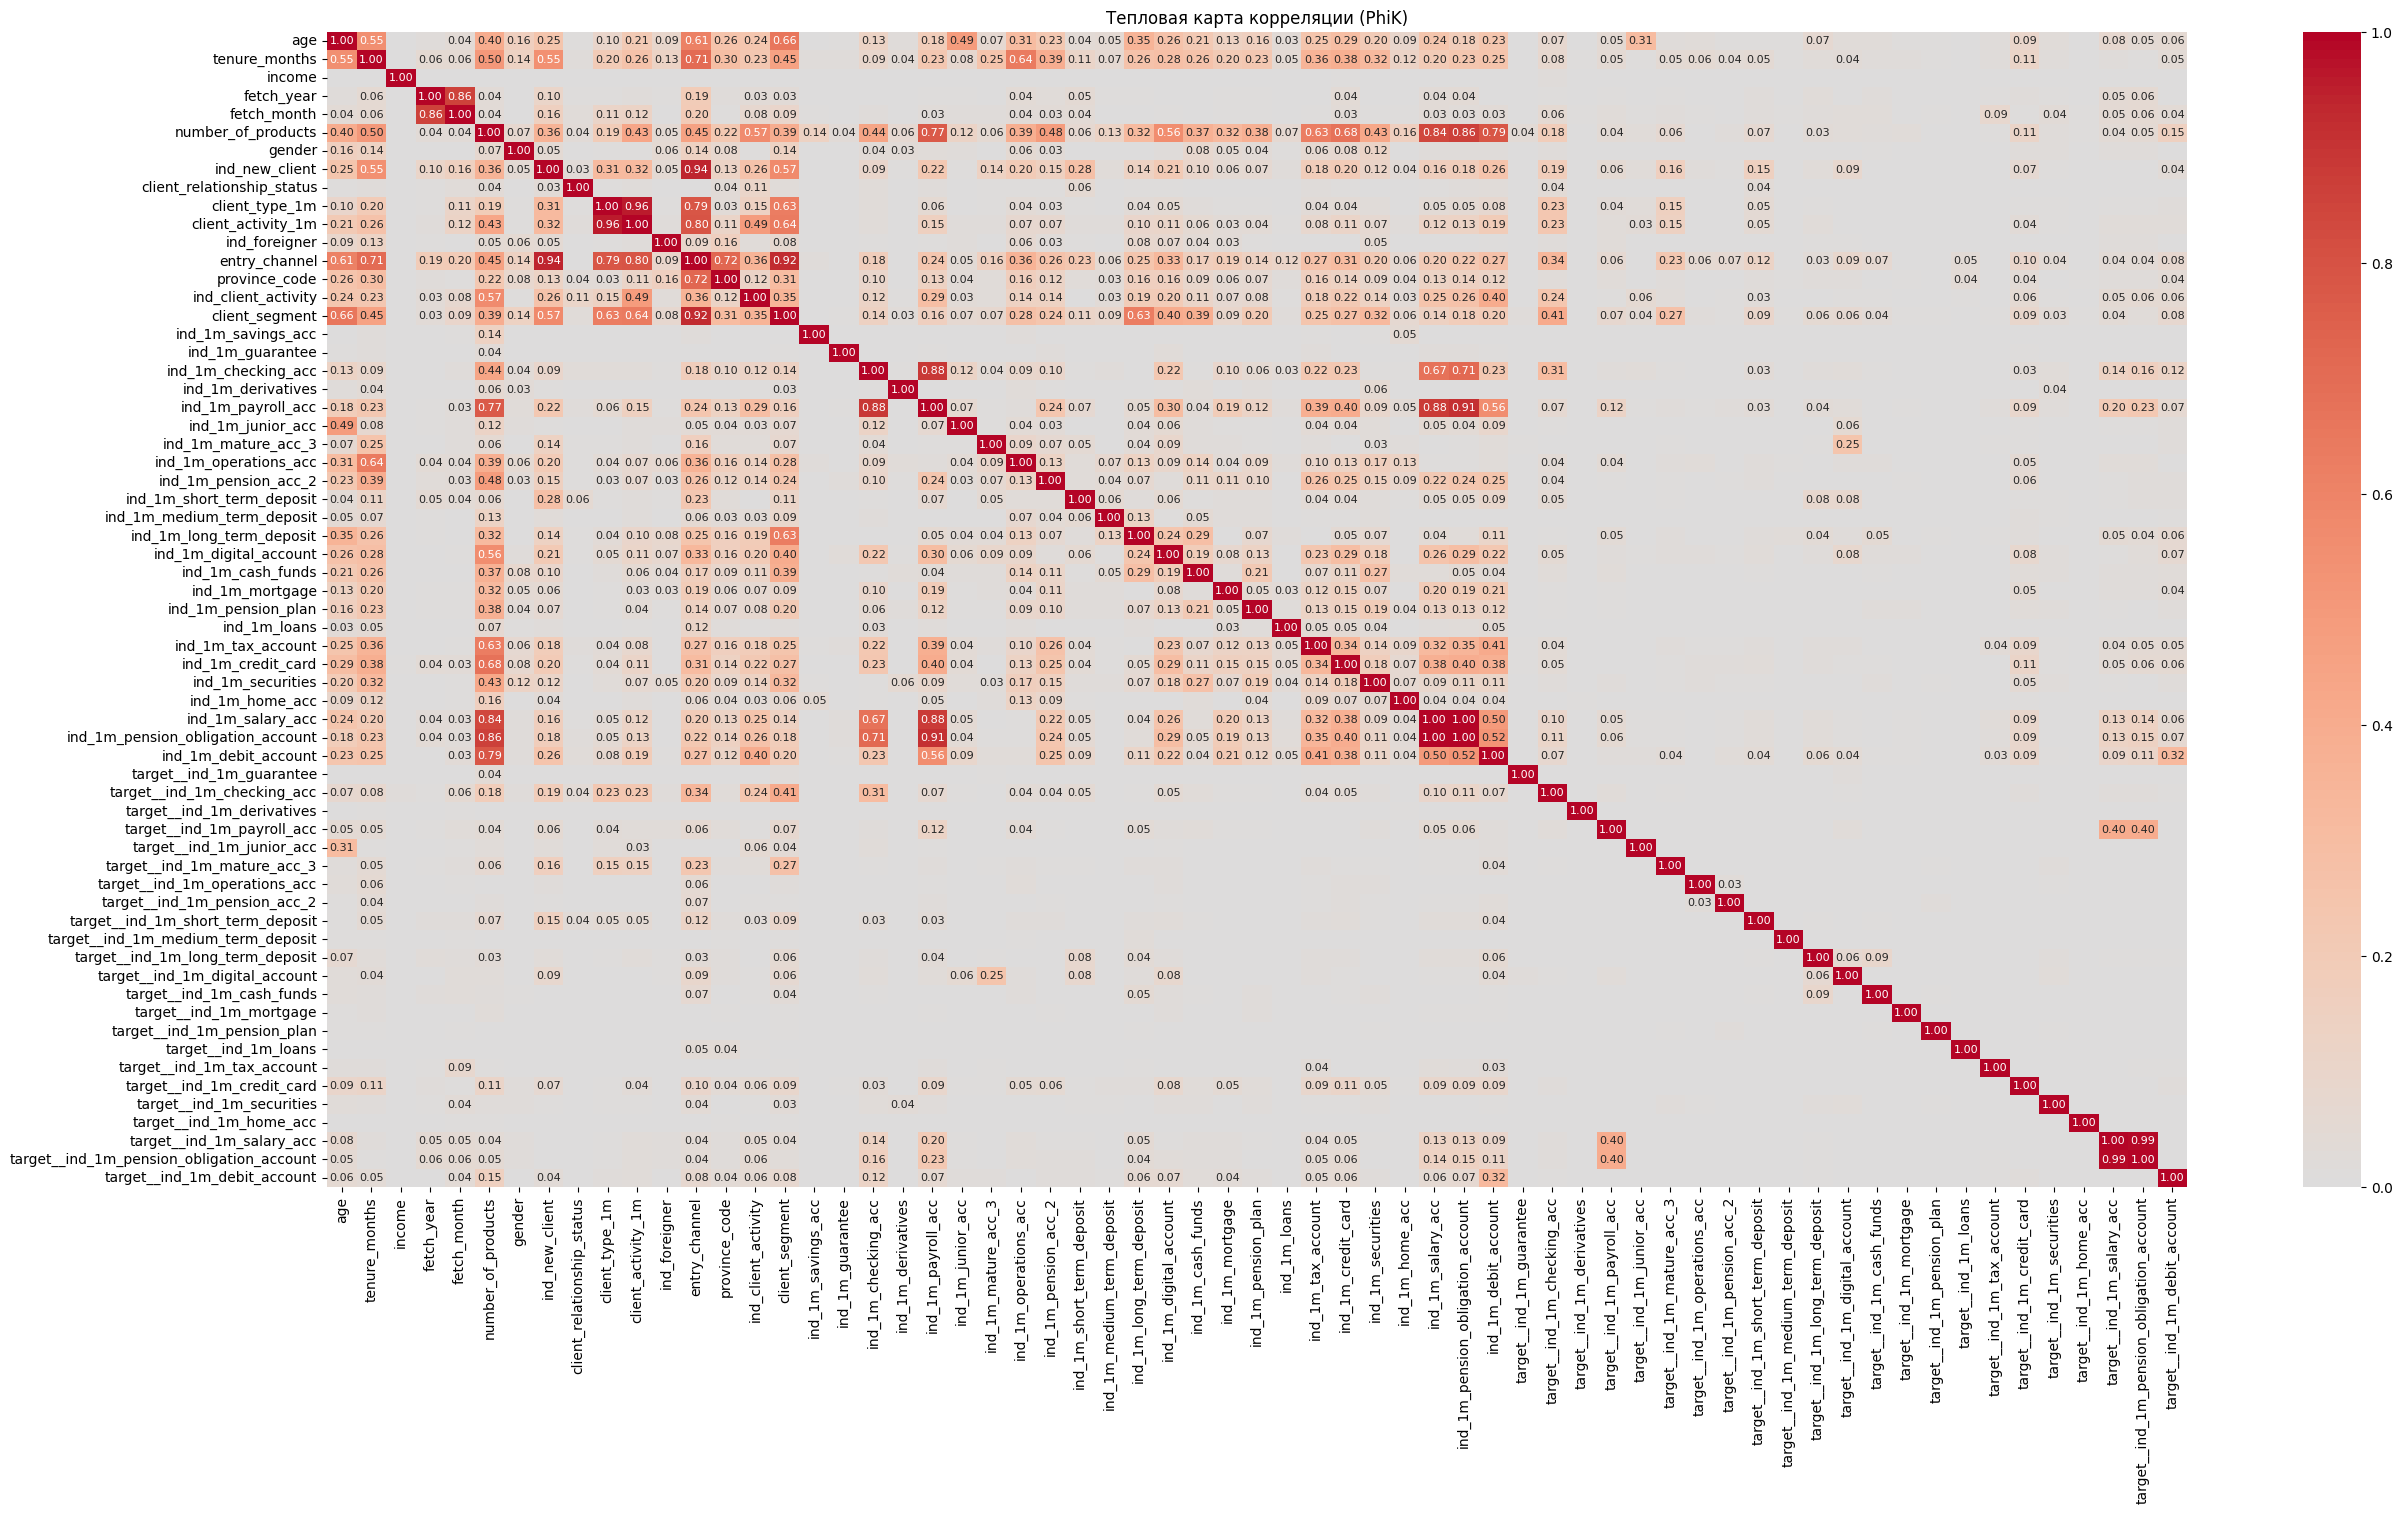

In [24]:
warnings.filterwarnings('ignore')

phik_matrix = (
    df[numerical_features + category_features + product_features + targets]
    .sample(SAMPLE_SIZE, random_state=RANDOM_STATE)
    .phik_matrix(interval_cols=numerical_features)
)
annot_matrix = phik_matrix.copy().applymap(lambda v: f'{v:.2f}' if v > 0.03 else '')

plt.figure(figsize=(30,15))
sns.heatmap(phik_matrix, cmap='coolwarm', center=0, annot=annot_matrix, fmt='', annot_kws={"size": 8})
plt.title('Тепловая карта корреляции (PhiK)')

plt.show()

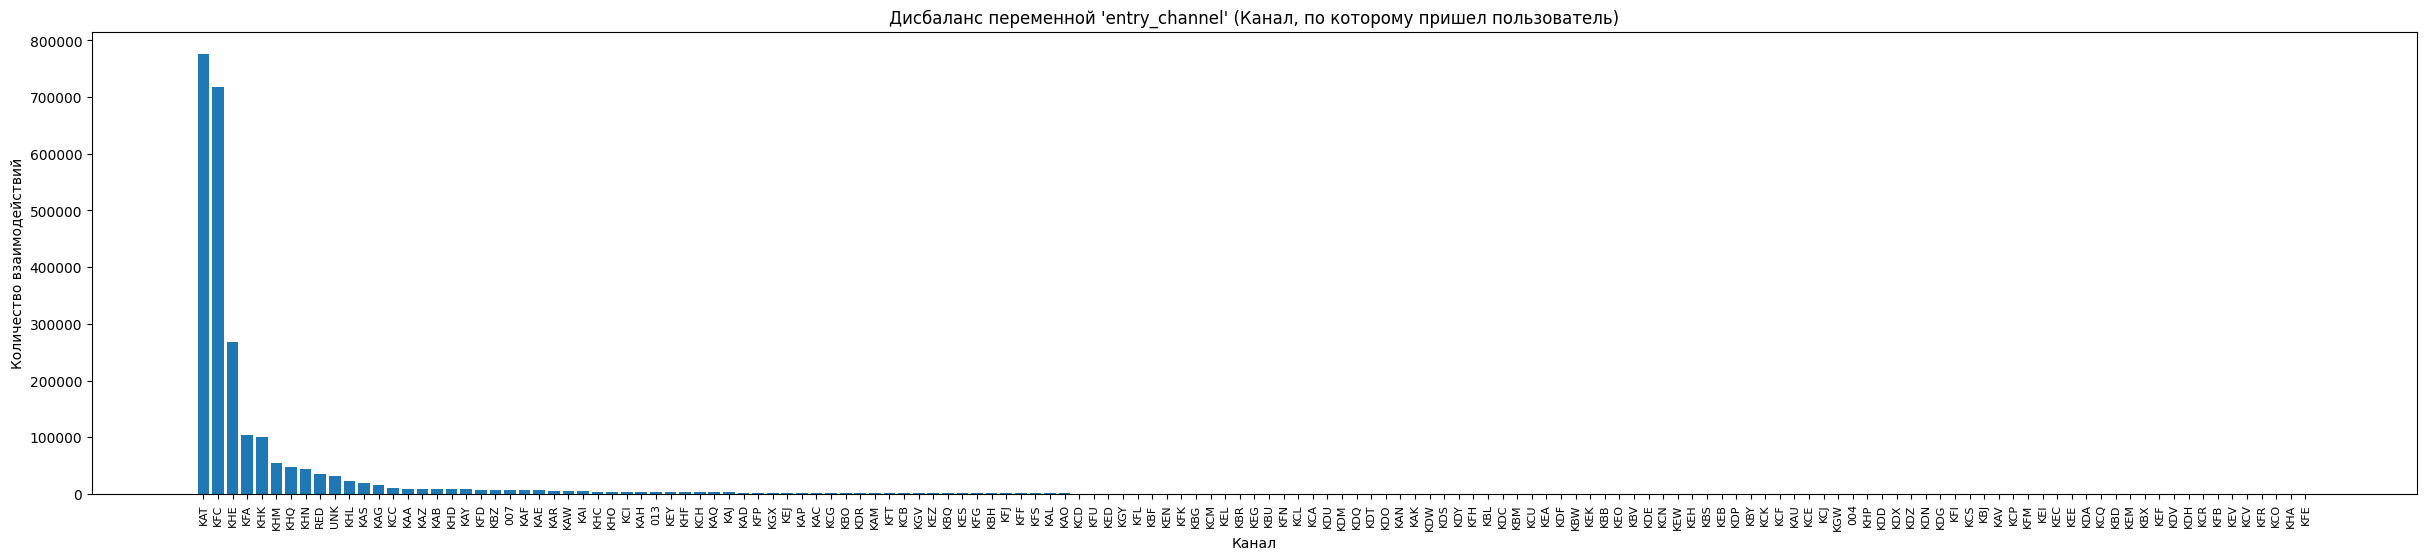

In [25]:
grouped = df.groupby('entry_channel').size().sort_values(ascending=False)

plt.figure(figsize=(30, 6))
plt.title(f"Дисбаланс переменной 'entry_channel' ({df.attrs['entry_channel'][0]})")
plt.xlabel("Канал")
plt.ylabel("Количество взаимодействий")
plt.xticks(rotation=90, fontsize=8)
plt.bar(grouped.index, grouped.values)
plt.show()

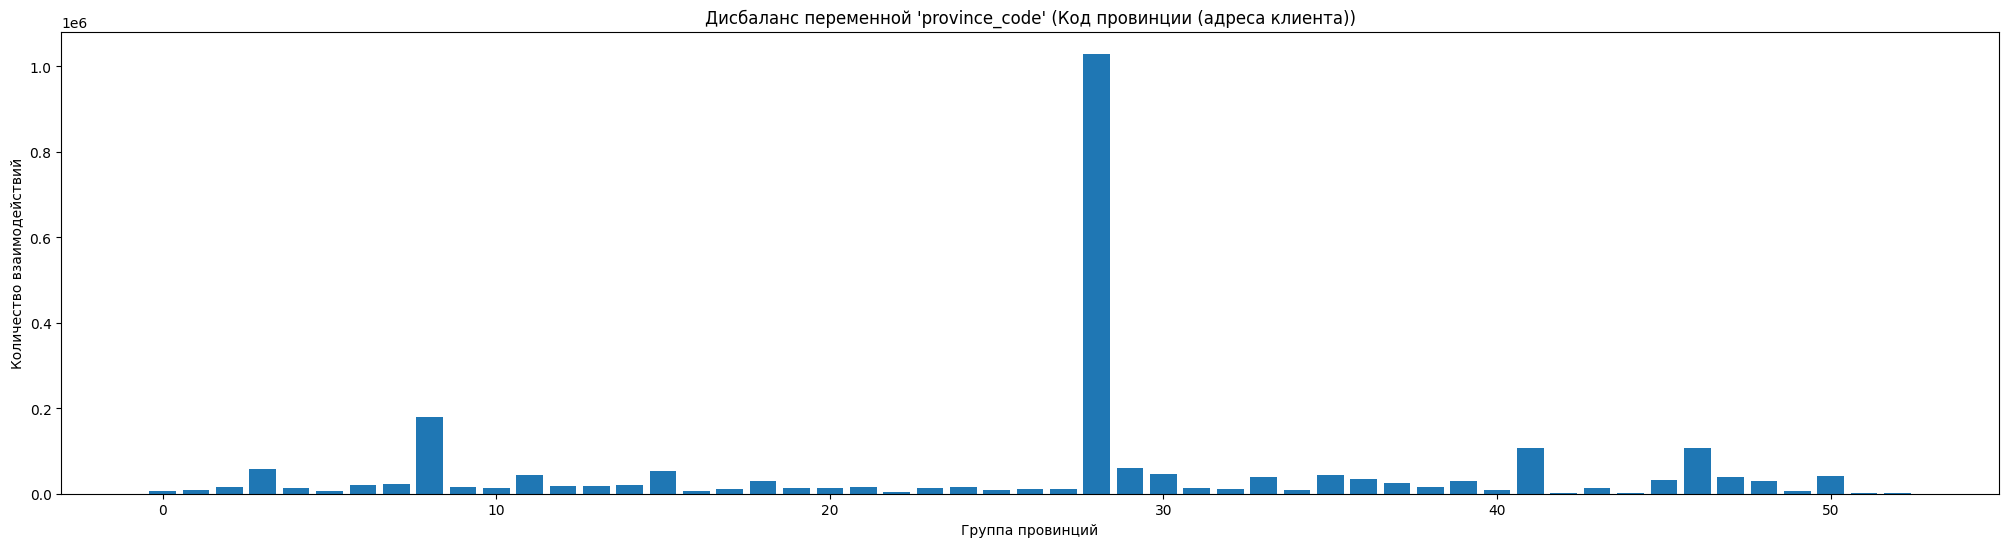

In [26]:
grouped = df.groupby('province_code', observed=True).size().sort_values(ascending=False)

plt.figure(figsize=(25, 6))
plt.title(f"Дисбаланс переменной 'province_code' ({df.attrs['province_code'][0]})")
plt.xlabel("Группа провинций")
plt.ylabel("Количество взаимодействий")
bars = plt.bar(grouped.index, grouped.values)

plt.show()

#### 3-я загрузка

In [27]:
def get_X_y(df, targets):
    df = df[df.isna().sum(axis=1) < 10]
    df = df[df['ind_deceased'] == 'N']
    return df.drop(columns= targets), df[targets]

df = pd.read_parquet(LOCAL_DATA_PATH + TRAIN_PARQUET)

X, y = get_X_y(df, df.attrs['target__'])

#### Encoding

In [28]:
class DataFrameProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        processed_X = process_df(X.copy())
        if y is not None:
            processed_y = y.loc[processed_X.index]
            return processed_X, processed_y
        return processed_X

processed_df = DataFrameProcessor().fit_transform(X)

numerical_columns = ['age', 'tenure_months', 'income', 'fetch_year', 'fetch_month', 'number_of_products']
freq_encode_columns = ['entry_channel', 'province_code']
one_hot_columns = ['gender', 'client_type_1m', 'client_activity_1m', 'ind_foreigner', 'client_segment']

display('numerical_columns:', display_statistics(processed_df[numerical_columns]))
display('freq_encode_columns:', display_statistics(processed_df[freq_encode_columns]))
display('one_hot_columns:', display_statistics(processed_df[one_hot_columns]))

'numerical_columns:'

,type,types,count,NaNs,zero_values,nunique,unique-top5
age,int64,{int64},2411240,0,0,111,"{44: 81427, 43: 81155, 42: 79535, 45: 78965, 4..."
tenure_months,int64,{int64},2411240,0,38449,254,"{3: 40317, 1: 40200, 4: 39693, 2: 39585, 0: 38..."
income,float64,{float64},2411240,0,0,129555,"{108625.77: 406852, 451931.22: 1244, 181042.2:..."
fetch_year,int32,{int32},2411240,0,0,2,"{2015: 2022312, 2016: 388928}"
fetch_month,int32,{int32},2411240,0,0,12,"{2: 348622, 1: 343667, 12: 190173, 11: 187706,..."
number_of_products,int64,{int64},2411240,0,84881,16,"{1: 640754, 2: 575943, 3: 363545, 4: 264385, 5..."


'freq_encode_columns:'

,type,types,count,NaNs,zero_values,nunique,unique-top5
entry_channel,object,{str},2411240,0,0,145,"{'KAT': 776385, 'KFC': 718513, 'KHE': 267239, ..."
province_code,int64,{int64},2411240,0,7101,53,"{28: 1029557, 8: 180012, 41: 107524, 46: 10661..."


'one_hot_columns:'

,type,types,count,NaNs,zero_values,nunique,unique-top5
gender,object,{str},2411240,0,0,2,"{'V': 1458127, 'H': 953113}"
client_type_1m,int64,{int64},2411240,0,28260,5,"{1: 2380481, 0: 28260, 3: 1905, 2: 467, 4: 127}"
client_activity_1m,object,{str},2411240,0,0,5,"{'A': 2174595, 'I': 206353, 'N': 27845, 'P': 2..."
ind_foreigner,object,{str},2411240,0,0,2,"{'N': 2300585, 'S': 110655}"
client_segment,int64,{int64},2411240,0,32201,4,"{2: 1620376, 3: 470840, 1: 287823, 0: 32201}"


#### Моделирование

In [29]:
def frequency_encoding(X):
    X_copy = X.copy()
    for col in X_copy.columns:
        freq_map = X_copy[col].value_counts(normalize=True).to_dict()
        X_copy[col] = X_copy[col].map(freq_map)
    return X_copy


column_transformer = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_columns),
        ('onehot', OneHotEncoder(drop='first'), one_hot_columns),
        ('freq', FunctionTransformer(frequency_encoding), freq_encode_columns)
    ], 
    remainder='passthrough',
    force_int_remainder_cols=False,
)

model = Pipeline(steps=[
    ('preprocessor', DataFrameProcessor()),
    ('encoder', column_transformer),
    ('model', MultiOutputClassifier(
        CatBoostClassifier(iterations=100, verbose=0, class_weights = [1, 4])
    ))
])


In [30]:
joblib.dump(model, LOCAL_MODEL_PATH + "model.pkl")

['models/model.pkl']